# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

In [1]:
!nvidia-smi

Mon Apr  3 15:39:07 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P8               20W /  N/A|   1174MiB / 16384MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Download and import required packages

In [2]:
# !pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
# !pip install --upgrade jupyter ipywidgets

In [3]:
# !git clone https://github.com/pytorch/fairseq.git
# !cd fairseq && git checkout 9a1c497
# !pip install --upgrade ./fairseq/

In [4]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [5]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset

## En-Zh Bilingual Parallel Corpus
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - Raw: 398,066 (sentences)   
    - Processed: 393,980 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

## Dataset Download

In [6]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
# urls = (
#     "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted2020.tgz",
#     "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/test.tgz",
# )
# file_names = (
#     'ted2020.tgz', # train & dev
#     'test.tgz', # test
# )
prefix = Path(data_dir).absolute() / dataset_name

# prefix.mkdir(parents=True, exist_ok=True)
# for u, f in zip(urls, file_names):
#     path = prefix/f
#     if not path.exists():
#         !wget {u} -O {path}
#     if path.suffix == ".tgz":
#         !tar -xvf {path} -C {prefix}
#     elif path.suffix == ".zip":
#         !unzip -o {path} -d {prefix}
# !mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
# !mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
# !mv {prefix/'test/test.en'} {prefix/'test.raw.en'}
# !mv {prefix/'test/test.zh'} {prefix/'test.raw.zh'}
# !rm -rf {prefix/'test'}

## Language

In [7]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = os.path.join(prefix, "train_dev.raw") # f'{prefix}/train_dev.raw'
test_prefix = os.path.join(prefix, "test.raw") # f'{prefix}/test.raw'

In [8]:
!head "{data_prefix+'.'+src_lang}" -n 5
!head "{data_prefix+'.'+tgt_lang}" -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## Preprocess files

In [9]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [10]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\DATA\rawdata\ted2020\train_dev.raw.clean.en & zh exists. skipping clean.
d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\DATA\rawdata\ted2020\test.raw.clean.en & zh exists. skipping clean.


In [11]:
!head "{data_prefix+'.clean.'+src_lang}" -n 5
!head "{data_prefix+'.clean.'+tgt_lang}" -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## Split into train/valid

In [12]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [13]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [14]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\DATA\rawdata\ted2020/spm8000.model exists. skipping spm_train.


In [15]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\DATA\rawdata\ted2020\train.en exists. skipping spm_encode.
d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\DATA\rawdata\ted2020\train.zh exists. skipping spm_encode.
d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\DATA\rawdata\ted2020\valid.en exists. skipping spm_encode.
d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\DATA\rawdata\ted2020\valid.zh exists. skipping spm_encode.
d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\DATA\rawdata\ted2020\test.en exists. skipping spm_encode.
d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\DATA\rawdata\ted2020\test.zh exists. skipping spm_encode.


In [16]:
!head "{data_dir+'/'+dataset_name+'/train.'+src_lang}" -n 5
!head "{data_dir+'/'+dataset_name+'/train.'+tgt_lang}" -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


## Binarize the data with fairseq

In [17]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref "{prefix/'train'}"\
        --validpref "{prefix/'valid'}"\
        --testpref "{prefix/'test'}"\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA\data-bin\ted2020 exists, will not overwrite!


# Configuration for experiments

In [18]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=100,
    start_epoch=1,
    
    # early stop patience if no improvement
    early_stop_patience=3,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [19]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environments

In [20]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2023-04-03 15:39:26 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2023-04-03 15:39:26 | INFO | fairseq.utils | rank   0: capabilities =  8.6  ; total memory = 16.000 GB ; name = NVIDIA GeForce RTX 3080 Laptop GPU      
2023-04-03 15:39:26 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [21]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2023-04-03 15:39:28 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2023-04-03 15:39:28 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [22]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2023-04-03 15:39:28 | INFO | hw5.seq2seq | loading data for epoch 1
2023-04-03 15:39:28 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020\train.en-zh.en
2023-04-03 15:39:28 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020\train.en-zh.zh
2023-04-03 15:39:28 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390041 examples
2023-04-03 15:39:28 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020\valid.en-zh.en
2023-04-03 15:39:28 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020\valid.en-zh.zh
2023-04-03 15:39:28 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3939 examples


In [23]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  18,   14,    6, 2234,   60,   19,   80,    5,  256,   16,  405, 1407,
        1706,    7,    2]),
 'target': tensor([ 140,  690,   28,  270,   45,  151, 1142,  660,  606,  369, 3114, 2434,
        1434,  192,    2])}
"Source: that's exactly what i do optical mind control ."
'Target: 這實在就是我所做的--光學操控思想'


# Dataset iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```



In [24]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2023-04-03 15:39:31 | WARNING | fairseq.tasks.fairseq_task | 2,532 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[29, 135, 2444, 3058, 682, 731, 235, 1558, 3383, 559]


{'id': tensor([723]),
 'nsentences': 1,
 'ntokens': 18,
 'net_input': {'src_tokens': tensor([[   1,    1,    1,    1,    1,   18,   26,   82,    8,  480,   15,  651,
           1361,   38,    6,  176, 2696,   39,    5,  822,   92,  260,    7,    2]]),
  'src_lengths': tensor([19]),
  'prev_output_tokens': tensor([[   2,  140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,
            151, 2691,    9,  215, 1680,   10,    1,    1,    1,    1,    1,    1]])},
 'target': tensor([[ 140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,  151,
          2691,    9,  215, 1680,   10,    2,    1,    1,    1,    1,    1,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [25]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

# Encoder

- The Encoder is a RNN or Transformer Encoder. The following description is for RNN. For every input token, Encoder will generate a output vector and a hidden states vector, and the hidden states vector is passed on to the next step. In other words, the Encoder sequentially reads in the input sequence, and outputs a single vector at each timestep, then finally outputs the final hidden states, or content vector, at the last timestep.
- Parameters:
  - *args*
      - encoder_embed_dim: the dimension of embeddings, this compresses the one-hot vector into fixed dimensions, which achieves dimension reduction
      - encoder_ffn_embed_dim is the dimension of hidden states and output vectors
      - encoder_layers is the number of layers for Encoder RNN
      - dropout determines the probability of a neuron's activation being set to 0, in order to prevent overfitting. Generally this is applied in training, and removed in testing.
  - *dictionary*: the dictionary provided by fairseq. it's used to obtain the padding index, and in turn the encoder padding mask. 
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)

- Inputs: 
    - *src_tokens*: integer sequence representing english e.g. 1, 28, 29, 205, 2 
- Outputs: 
    - *outputs*: the output of RNN at each timestep, can be furthur processed by Attention
    - *final_hiddens*: the hidden states of each timestep, will be passed to decoder for decoding
    - *encoder_padding_mask*: this tells the decoder which position to ignore


In [26]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # pass thru bidirectional RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # Since Encoder is bidirectional, we need to concatenate the hidden states of two directions
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- When the input sequence is long, "content vector" alone cannot accurately represent the whole sequence, attention mechanism can provide the Decoder more information.
- According to the **Decoder embeddings** of the current timestep, match the **Encoder outputs** with decoder embeddings to determine correlation, and then sum the Encoder outputs weighted by the correlation as the input to **Decoder** RNN.
- Common attention implementations use neural network / dot product as the correlation between **query** (decoder embeddings) and **key** (Encoder outputs), followed by **softmax**  to obtain a distribution, and finally **values** (Encoder outputs) is **weighted sum**-ed by said distribution.

- Parameters:
  - *input_embed_dim*: dimensionality of key, should be that of the vector in decoder to attend others
  - *source_embed_dim*: dimensionality of query, should be that of the vector to be attended to (encoder outputs)
  - *output_embed_dim*: dimensionality of value, should be that of the vector after attention, expected by the next layer

- Inputs: 
    - *inputs*: is the key, the vector to attend to others
    - *encoder_outputs*:  is the query/value, the vector to be attended to
    - *encoder_padding_mask*: this tells the decoder which position to ignore
- Outputs: 
    - *output*: the context vector after attention
    - *attention score*: the attention distribution


In [27]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

# Decoder

* The hidden states of **Decoder** will be initialized by the final hidden states of **Encoder** (the content vector)
* At the same time, **Decoder** will change its hidden states based on the input of the current timestep (the outputs of previous timesteps), and generates an output
* Attention improves the performance
* The seq2seq steps are implemented in decoder, so that later the Seq2Seq class can accept RNN and Transformer, without furthur modification.
- Parameters:
  - *args*
      - decoder_embed_dim: is the dimensionality of the decoder embeddings, similar to encoder_embed_dim，
      - decoder_ffn_embed_dim: is the dimensionality of the decoder RNN hidden states, similar to encoder_ffn_embed_dim
      - decoder_layers: number of layers of RNN decoder
      - share_decoder_input_output_embed: usually, the projection matrix of the decoder will share weights with the decoder input embeddings
  - *dictionary*: the dictionary provided by fairseq
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)
- Inputs: 
    - *prev_output_tokens*: integer sequence representing the right-shifted target e.g. 1, 28, 29, 205, 2 
    - *encoder_out*: encoder's output.
    - *incremental_state*: in order to speed up decoding during test time, we will save the hidden state of each timestep. see forward() for details.
- Outputs: 
    - *outputs*: the logits (before softmax) output of decoder for each timesteps
    - *extra*: unsused

In [28]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # extract the outputs from encoder
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # if the information from last timestep is retained, we can continue from there instead of starting from bos
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # incremental state does not exist, either this is training time, or the first timestep of test time
            # prepare for seq2seq: pass the encoder_hidden to the decoder hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # pass thru unidirectional RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # project to embedding size (if hidden differs from embed size, and share_embedding is True, 
        # we need to do an extra projection)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # project to vocab size
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # if incremental, record the hidden states of current timestep, which will be restored in the next timestep
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [29]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [30]:
# # HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
    decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)
    # encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    # decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [31]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=512,
    encoder_layers=1,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=1,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

# add_transformer_args(arch_args)

In [32]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [33]:
model = build_model(arch_args, task)
logger.info(model)

d:\miniforge3\envs\machine-learning\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
2023-04-03 15:39:51 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): RNNEncoder(
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (dropout_in_module): Dropout(p=0.3, inplace=False)
    (rnn): GRU(256, 512, dropout=0.3, bidirectional=True)
    (dropout_out_module): Dropout(p=0.3, inplace=False)
  )
  (decoder): RNNDecoder(
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (dropout_in_module): Dropout(p=0.3, inplace=False)
    (rnn): GRU(256, 1024, dropout=0.3)
    (attention): AttentionLayer(
      (input_proj): Linear(in_features=256, out_features=1024, bias=False)
      (output_proj): Linear(in_features=1280, out_features=256, bias=False)
    )
    (dropout

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [34]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$

In [35]:
def get_rate(d_model, step_num, warmup_step):
    # TODO: Change lr from constant to the equation shown above
    # lr = 0.001
    lr = d_model ** (-0.5) * min(step_num ** (-0.5), step_num * warmup_step ** (-1.5)) 
    return lr

In [36]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

## Scheduling Visualized

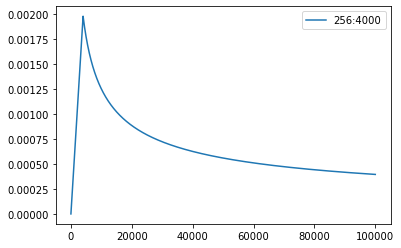

In [37]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [38]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": [], "gnorm": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        stats["gnorm"].append(gnorm.item())
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [39]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [40]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights


In [41]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [42]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [43]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2023-04-03 15:40:12 | INFO | hw5.seq2seq | task: TranslationTask
2023-04-03 15:40:12 | INFO | hw5.seq2seq | encoder: RNNEncoder
2023-04-03 15:40:12 | INFO | hw5.seq2seq | decoder: RNNDecoder
2023-04-03 15:40:12 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2023-04-03 15:40:12 | INFO | hw5.seq2seq | optimizer: NoamOpt
2023-04-03 15:40:12 | INFO | hw5.seq2seq | num. model params: 11,251,968 (num. trained: 11,251,968)
2023-04-03 15:40:12 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [44]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
bleu_best, early_stop_cnt = 0.0, 0
gnorms = []
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_stats = train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)
    
    gnorms += train_stats["gnorm"]
    
    if stats["bleu"].score > bleu_best:
        bleu_best = stats["bleu"].score
        early_stop_cnt = 0
    else:
        early_stop_cnt += 1
    
    if early_stop_cnt > config.early_stop_patience:
        print(f"No improvements in the recent {config.early_stop_patience} epochs. So far the best BLEU score={bleu_best:.5f}")
        break

2023-04-03 15:40:13 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2023-04-03 15:40:13 | INFO | hw5.seq2seq | no checkpoints found at checkpoints\rnn\checkpoint_last.pt!
2023-04-03 15:40:19 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 1:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 15:41:47 | INFO | hw5.seq2seq | training loss: 7.0693
2023-04-03 15:41:47 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 15:42:09 | INFO | hw5.seq2seq | example source: so low income here , high income there .
2023-04-03 15:42:09 | INFO | hw5.seq2seq | example hypothesis: 我 , 一年 , 一年 , 會 。 」
2023-04-03 15:42:09 | INFO | hw5.seq2seq | example reference: 所以這裡是收入低的 , 這裡是收入高的
2023-04-03 15:42:09 | INFO | hw5.seq2seq | validation loss:	6.5453
2023-04-03 15:42:09 | INFO | hw5.seq2seq | BLEU = 0.04 11.2/0.4/0.0/0.0 (BP = 0.727 ratio = 0.759 hyp_len = 84812 ref_len = 111811)
2023-04-03 15:42:09 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint1.pt
2023-04-03 15:42:09 | INFO | hw5.seq2seq | end of epoch 1
2023-04-03 15:42:09 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 2:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 15:43:37 | INFO | hw5.seq2seq | training loss: 6.3406
2023-04-03 15:43:37 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 15:43:51 | INFO | hw5.seq2seq | example source: you should have started with z .
2023-04-03 15:43:51 | INFO | hw5.seq2seq | example hypothesis: 所以 , 很棒的 。
2023-04-03 15:43:51 | INFO | hw5.seq2seq | example reference: 要從z開始讀 。
2023-04-03 15:43:51 | INFO | hw5.seq2seq | validation loss:	6.0007
2023-04-03 15:43:51 | INFO | hw5.seq2seq | BLEU = 0.83 24.3/3.2/0.6/0.1 (BP = 0.537 ratio = 0.616 hyp_len = 68927 ref_len = 111811)
2023-04-03 15:43:51 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint2.pt
2023-04-03 15:43:51 | INFO | hw5.seq2seq | end of epoch 2
2023-04-03 15:43:51 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 3:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 15:45:19 | INFO | hw5.seq2seq | training loss: 5.8162
2023-04-03 15:45:19 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 15:45:36 | INFO | hw5.seq2seq | example source: grouper ?
2023-04-03 15:45:36 | INFO | hw5.seq2seq | example hypothesis: 誰嗎 ?
2023-04-03 15:45:36 | INFO | hw5.seq2seq | example reference: 石斑魚 ?
2023-04-03 15:45:36 | INFO | hw5.seq2seq | validation loss:	5.4317
2023-04-03 15:45:36 | INFO | hw5.seq2seq | BLEU = 1.93 18.5/3.4/0.9/0.2 (BP = 1.000 ratio = 1.009 hyp_len = 112847 ref_len = 111811)
2023-04-03 15:45:36 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint3.pt
2023-04-03 15:45:36 | INFO | hw5.seq2seq | end of epoch 3
2023-04-03 15:45:36 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 4:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 15:47:03 | INFO | hw5.seq2seq | training loss: 5.3725
2023-04-03 15:47:03 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 15:47:21 | INFO | hw5.seq2seq | example source: it's very destructive , but it also catalyzes the production of vitamin d in the skin , vitamin d being a molecule that we very much need for our strong bones , the health of our immune system , and myriad other important functions in our bodies .
2023-04-03 15:47:21 | INFO | hw5.seq2seq | example hypothesis: 很顯然 , 最重要的是 , 最重要的是 , 最重要的是 , 最重要的是 , 最重要的是 , 最重要的是 , 最重要的是 , 最重要的是 , 最重要的是 , 最重要的是 , 人類的性別 , 尤其是 , 除了我們對抗生素的影響力 , 尤其是 , 除了我們對抗生素的影響力 。
2023-04-03 15:47:21 | INFO | hw5.seq2seq | example reference: uvb非常的有破壞性 , 但是它也催化皮膚裡維生素d的生產 。 維生素d是我們非常需要的一種分子 , 它幫助強健骨骼、增強免疫系統、還有在我們身體裡行使其他各式各樣的重要功能 。
2023-04-03 15:47:21 | INFO | hw5.seq2seq | validation loss:	5.0045
2023-04-03 15:47:21 | INFO | hw5.seq2seq | BLEU = 4.62 22.5/6.6/2.6/1.2 (BP = 1.000 ratio = 1.183 hyp_len = 132281 ref_len = 111811)
2023-04-03 15:47:21 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoin

train epoch 5:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 15:48:49 | INFO | hw5.seq2seq | training loss: 4.9737
2023-04-03 15:48:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 15:49:05 | INFO | hw5.seq2seq | example source: it's what we call , " invest , connect and celebrate . "
2023-04-03 15:49:05 | INFO | hw5.seq2seq | example hypothesis: 我們稱之為 「 投資和平衡 」 。
2023-04-03 15:49:05 | INFO | hw5.seq2seq | example reference: 也就是我們稱之為『投資 , 連結 , 發揚光大』
2023-04-03 15:49:05 | INFO | hw5.seq2seq | validation loss:	4.5962
2023-04-03 15:49:05 | INFO | hw5.seq2seq | BLEU = 10.02 34.9/14.5/7.0/3.5 (BP = 0.946 ratio = 0.947 hyp_len = 105903 ref_len = 111811)
2023-04-03 15:49:05 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint5.pt
2023-04-03 15:49:05 | INFO | hw5.seq2seq | end of epoch 5
2023-04-03 15:49:05 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 6:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 15:50:33 | INFO | hw5.seq2seq | training loss: 4.7192
2023-04-03 15:50:33 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 15:50:50 | INFO | hw5.seq2seq | example source: thank you very much .
2023-04-03 15:50:50 | INFO | hw5.seq2seq | example hypothesis: 非常感謝各位 。
2023-04-03 15:50:50 | INFO | hw5.seq2seq | example reference: 謝謝各位 。
2023-04-03 15:50:50 | INFO | hw5.seq2seq | validation loss:	4.3781
2023-04-03 15:50:50 | INFO | hw5.seq2seq | BLEU = 10.49 32.7/14.3/7.1/3.7 (BP = 1.000 ratio = 1.136 hyp_len = 126986 ref_len = 111811)
2023-04-03 15:50:50 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint6.pt
2023-04-03 15:50:50 | INFO | hw5.seq2seq | end of epoch 6
2023-04-03 15:50:50 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 7:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 15:52:17 | INFO | hw5.seq2seq | training loss: 4.5516
2023-04-03 15:52:17 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 15:52:35 | INFO | hw5.seq2seq | example source: thank you very much .
2023-04-03 15:52:35 | INFO | hw5.seq2seq | example hypothesis: 感謝各位 。
2023-04-03 15:52:35 | INFO | hw5.seq2seq | example reference: 非常感謝
2023-04-03 15:52:35 | INFO | hw5.seq2seq | validation loss:	4.2769
2023-04-03 15:52:35 | INFO | hw5.seq2seq | BLEU = 11.13 33.4/15.0/7.6/4.0 (BP = 1.000 ratio = 1.151 hyp_len = 128711 ref_len = 111811)
2023-04-03 15:52:35 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint7.pt
2023-04-03 15:52:35 | INFO | hw5.seq2seq | end of epoch 7
2023-04-03 15:52:35 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 8:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 15:54:02 | INFO | hw5.seq2seq | training loss: 4.4422
2023-04-03 15:54:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 15:54:19 | INFO | hw5.seq2seq | example source: some will go on for further education , but many will enter the workforce .
2023-04-03 15:54:19 | INFO | hw5.seq2seq | example hypothesis: 有些人會進入職業 , 但很多人會進入工作 。
2023-04-03 15:54:19 | INFO | hw5.seq2seq | example reference: 有些人會繼續深造 , 但許多人會成為勞動力 。
2023-04-03 15:54:19 | INFO | hw5.seq2seq | validation loss:	4.1770
2023-04-03 15:54:19 | INFO | hw5.seq2seq | BLEU = 13.62 38.7/18.3/9.4/5.2 (BP = 1.000 ratio = 1.010 hyp_len = 112947 ref_len = 111811)
2023-04-03 15:54:19 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint8.pt
2023-04-03 15:54:19 | INFO | hw5.seq2seq | end of epoch 8
2023-04-03 15:54:19 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 9:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 15:55:46 | INFO | hw5.seq2seq | training loss: 4.3619
2023-04-03 15:55:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 15:56:03 | INFO | hw5.seq2seq | example source: what would i feel ?
2023-04-03 15:56:03 | INFO | hw5.seq2seq | example hypothesis: 我會覺得什麼 ?
2023-04-03 15:56:03 | INFO | hw5.seq2seq | example reference: 會有甚麼感覺呢 ?
2023-04-03 15:56:03 | INFO | hw5.seq2seq | validation loss:	4.1210
2023-04-03 15:56:03 | INFO | hw5.seq2seq | BLEU = 14.01 39.2/18.7/9.8/5.4 (BP = 1.000 ratio = 1.046 hyp_len = 116907 ref_len = 111811)
2023-04-03 15:56:03 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint9.pt
2023-04-03 15:56:03 | INFO | hw5.seq2seq | end of epoch 9
2023-04-03 15:56:03 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 10:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 15:57:31 | INFO | hw5.seq2seq | training loss: 4.3014
2023-04-03 15:57:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 15:57:48 | INFO | hw5.seq2seq | example source: so think about when you have friends , families and coworkers in california , on the west coast or in other parts of the world .
2023-04-03 15:57:48 | INFO | hw5.seq2seq | example hypothesis: 所以 , 想想看 , 當你有朋友、家庭和同事在加州 , 在加州 , 在加州 , 在加州 , 在加州 , 在加州 , 到西岸或其他地方 。
2023-04-03 15:57:48 | INFO | hw5.seq2seq | example reference: 所以 , 想像當你嘗試聯繫在加州 , 在西海岸或者在世界的另一面
2023-04-03 15:57:48 | INFO | hw5.seq2seq | validation loss:	4.0689
2023-04-03 15:57:48 | INFO | hw5.seq2seq | BLEU = 14.42 39.3/19.1/10.2/5.7 (BP = 1.000 ratio = 1.064 hyp_len = 118970 ref_len = 111811)
2023-04-03 15:57:48 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint10.pt
2023-04-03 15:57:48 | INFO | hw5.seq2seq | end of epoch 10
2023-04-03 15:57:48 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 11:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 15:59:16 | INFO | hw5.seq2seq | training loss: 4.2534
2023-04-03 15:59:16 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 15:59:34 | INFO | hw5.seq2seq | example source: okay , so by this logic , bad is always stronger than good when it comes to updating .
2023-04-03 15:59:34 | INFO | hw5.seq2seq | example hypothesis: 嗯 , 這樣的邏輯 , 糟糕的比好 , 比好好 , 就會更強壯 。
2023-04-03 15:59:34 | INFO | hw5.seq2seq | example reference: 好 , 依據這樣的邏輯當有新的印象出現時壞的效果比好的效果來得強烈
2023-04-03 15:59:34 | INFO | hw5.seq2seq | validation loss:	4.0334
2023-04-03 15:59:34 | INFO | hw5.seq2seq | BLEU = 15.20 41.3/20.2/10.7/6.0 (BP = 1.000 ratio = 1.032 hyp_len = 115429 ref_len = 111811)
2023-04-03 15:59:34 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint11.pt
2023-04-03 15:59:34 | INFO | hw5.seq2seq | end of epoch 11
2023-04-03 15:59:34 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 12:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:01:05 | INFO | hw5.seq2seq | training loss: 4.2160
2023-04-03 16:01:05 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:01:23 | INFO | hw5.seq2seq | example source: never mind the fact that the address led to a strip mall somewhere in northern l . a .
2023-04-03 16:01:23 | INFO | hw5.seq2seq | example hypothesis: 從來沒有注意到 , 在北爾的某個地方 , 在北加爾的地址上升了一大堆 。
2023-04-03 16:01:23 | INFO | hw5.seq2seq | example reference: 但事實是這個公司位於洛杉磯北部的某購物中心
2023-04-03 16:01:23 | INFO | hw5.seq2seq | validation loss:	4.0040
2023-04-03 16:01:23 | INFO | hw5.seq2seq | BLEU = 15.68 44.6/21.9/11.7/6.6 (BP = 0.944 ratio = 0.946 hyp_len = 105745 ref_len = 111811)
2023-04-03 16:01:23 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint12.pt
2023-04-03 16:01:23 | INFO | hw5.seq2seq | end of epoch 12
2023-04-03 16:01:23 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 13:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:02:53 | INFO | hw5.seq2seq | training loss: 4.1811
2023-04-03 16:02:53 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:03:11 | INFO | hw5.seq2seq | example source: we wear all black , we get very depressed , you think we're adorable , we're dead inside because we've got no choice .
2023-04-03 16:03:11 | INFO | hw5.seq2seq | example hypothesis: 我們穿著黑色 , 我們很沮喪 , 很憂鬱 , 你覺得我們很沮喪 , 很憂鬱 , 你覺得我們很沮喪 , 很沮喪 , 很憂鬱 , 你覺得我們很沮喪 。
2023-04-03 16:03:11 | INFO | hw5.seq2seq | example reference: 我們身著華服你們認為我們是值得尊敬的我們內心是一片死寂 , 因為我們別無選擇
2023-04-03 16:03:11 | INFO | hw5.seq2seq | validation loss:	3.9967
2023-04-03 16:03:11 | INFO | hw5.seq2seq | BLEU = 15.87 43.2/21.4/11.4/6.4 (BP = 0.984 ratio = 0.984 hyp_len = 110039 ref_len = 111811)
2023-04-03 16:03:11 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint13.pt
2023-04-03 16:03:11 | INFO | hw5.seq2seq | end of epoch 13
2023-04-03 16:03:11 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 14:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:04:41 | INFO | hw5.seq2seq | training loss: 4.1533
2023-04-03 16:04:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:04:58 | INFO | hw5.seq2seq | example source: he's saying to me , 'electricity . ' was he an electrician ? " " no . "
2023-04-03 16:04:58 | INFO | hw5.seq2seq | example hypothesis: 他對我說: 「 不 。 」 「 不 。 」
2023-04-03 16:04:58 | INFO | hw5.seq2seq | example reference: 他對我說『電流』他是一個電工嗎 ? 」 不是
2023-04-03 16:04:58 | INFO | hw5.seq2seq | validation loss:	3.9797
2023-04-03 16:04:58 | INFO | hw5.seq2seq | BLEU = 15.92 48.8/24.7/13.5/7.7 (BP = 0.846 ratio = 0.857 hyp_len = 95792 ref_len = 111811)
2023-04-03 16:04:58 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint14.pt
2023-04-03 16:04:58 | INFO | hw5.seq2seq | end of epoch 14
2023-04-03 16:04:58 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 15:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:06:27 | INFO | hw5.seq2seq | training loss: 4.1326
2023-04-03 16:06:27 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:06:45 | INFO | hw5.seq2seq | example source: so they went to their data science team , and they were able to scale this big data insight in with their quantitative data .
2023-04-03 16:06:45 | INFO | hw5.seq2seq | example hypothesis: 所以他們去找他們的資料科學團隊 , 他們可以把大量的資料資料放到他們的資料中 。
2023-04-03 16:06:45 | INFO | hw5.seq2seq | example reference: 於是叫他們的數據科學組把這洞察放大到量化數據的規模來衡量 。
2023-04-03 16:06:45 | INFO | hw5.seq2seq | validation loss:	3.9467
2023-04-03 16:06:45 | INFO | hw5.seq2seq | BLEU = 16.46 43.9/21.9/11.9/6.8 (BP = 0.987 ratio = 0.987 hyp_len = 110401 ref_len = 111811)
2023-04-03 16:06:45 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint15.pt
2023-04-03 16:06:45 | INFO | hw5.seq2seq | end of epoch 15
2023-04-03 16:06:45 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 16:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:08:15 | INFO | hw5.seq2seq | training loss: 4.1057
2023-04-03 16:08:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:08:32 | INFO | hw5.seq2seq | example source: in the 35 years i've been a climbing guide and taught on indoor walls , and stuff like that , the most important thing i've learned was , guys will always try to do pullups .
2023-04-03 16:08:32 | INFO | hw5.seq2seq | example hypothesis: 在35年裡 , 我學到的最重要的事是 , 人們總是試著去做靈魂 。
2023-04-03 16:08:32 | INFO | hw5.seq2seq | example reference: 35年來我一直擔任攀岩嚮導在室內岩場教學 , 並做些像這樣的工作 , 而我所學到的最重要的事情就是 , 男性們通常會做引體向上 。
2023-04-03 16:08:32 | INFO | hw5.seq2seq | validation loss:	3.9274
2023-04-03 16:08:32 | INFO | hw5.seq2seq | BLEU = 16.40 43.3/21.5/11.7/6.6 (BP = 1.000 ratio = 1.032 hyp_len = 115401 ref_len = 111811)
2023-04-03 16:08:32 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint16.pt
2023-04-03 16:08:32 | INFO | hw5.seq2seq | end of epoch 16
2023-04-03 16:08:32 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 17:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:10:02 | INFO | hw5.seq2seq | training loss: 4.0889
2023-04-03 16:10:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:10:20 | INFO | hw5.seq2seq | example source: who gets safe surgery and who doesn't ?
2023-04-03 16:10:20 | INFO | hw5.seq2seq | example hypothesis: 誰得到安全的手術 ? 誰會得到安全手術 ?
2023-04-03 16:10:20 | INFO | hw5.seq2seq | example reference: 誰能接受安全的手術誰不能 ?
2023-04-03 16:10:20 | INFO | hw5.seq2seq | validation loss:	3.9115
2023-04-03 16:10:20 | INFO | hw5.seq2seq | BLEU = 16.37 43.2/21.6/11.6/6.6 (BP = 1.000 ratio = 1.038 hyp_len = 116090 ref_len = 111811)
2023-04-03 16:10:20 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint17.pt
2023-04-03 16:10:20 | INFO | hw5.seq2seq | end of epoch 17
2023-04-03 16:10:20 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 18:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:11:51 | INFO | hw5.seq2seq | training loss: 4.0697
2023-04-03 16:11:51 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:12:08 | INFO | hw5.seq2seq | example source: they breathe easier .
2023-04-03 16:12:08 | INFO | hw5.seq2seq | example hypothesis: 他們呼吸比較容易 。
2023-04-03 16:12:08 | INFO | hw5.seq2seq | example reference: 他們比較能呼吸 。
2023-04-03 16:12:08 | INFO | hw5.seq2seq | validation loss:	3.9074
2023-04-03 16:12:08 | INFO | hw5.seq2seq | BLEU = 16.86 46.0/23.0/12.6/7.1 (BP = 0.960 ratio = 0.961 hyp_len = 107459 ref_len = 111811)
2023-04-03 16:12:08 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint18.pt
2023-04-03 16:12:08 | INFO | hw5.seq2seq | end of epoch 18
2023-04-03 16:12:08 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 19:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:13:37 | INFO | hw5.seq2seq | training loss: 4.0534
2023-04-03 16:13:37 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:13:55 | INFO | hw5.seq2seq | example source: all of the world's defense budgets and military spending taken together total just under two trillion dollars per year .
2023-04-03 16:13:55 | INFO | hw5.seq2seq | example hypothesis: 全世界的防禦預算和軍事花費在兩兆美元 。
2023-04-03 16:13:55 | INFO | hw5.seq2seq | example reference: 全球的軍事預算加總起來 , 每年都不到兩兆美金 。
2023-04-03 16:13:55 | INFO | hw5.seq2seq | validation loss:	3.8965
2023-04-03 16:13:55 | INFO | hw5.seq2seq | BLEU = 17.22 45.5/23.0/12.5/7.2 (BP = 0.983 ratio = 0.983 hyp_len = 109954 ref_len = 111811)
2023-04-03 16:13:55 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint19.pt
2023-04-03 16:13:55 | INFO | hw5.seq2seq | end of epoch 19
2023-04-03 16:13:55 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 20:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:15:25 | INFO | hw5.seq2seq | training loss: 4.0381
2023-04-03 16:15:25 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:15:42 | INFO | hw5.seq2seq | example source: how do these nielsen ratings reflect not just what you've heard about , which is the idea of our social , collective unconscious , but how do these top10 nielsenrated shows over 50 years reflect the idea of our social conscience ?
2023-04-03 16:15:42 | INFO | hw5.seq2seq | example hypothesis: 這些尼爾斯·雷特並不只是你剛剛所聽到的 , 關於我們的社群、集體的意識 , 而是如何 , 將這個想法帶給我們社會社會的觀點 , 如何反映出我們社會的社會觀點 ?
2023-04-03 16:15:42 | INFO | hw5.seq2seq | example reference: 尼爾森收視率調查如何反應出所謂的社會集體無意識 ? 尼爾森收視率調查又是如何在過去五十年中反應出我們社會的意識 ?
2023-04-03 16:15:42 | INFO | hw5.seq2seq | validation loss:	3.8775
2023-04-03 16:15:42 | INFO | hw5.seq2seq | BLEU = 17.17 44.9/22.5/12.3/7.0 (BP = 1.000 ratio = 1.005 hyp_len = 112322 ref_len = 111811)
2023-04-03 16:15:42 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint20.pt
2023-04-03 16:15:42 | INFO | hw5.seq2seq | end of epoch 20
2023-04-03 16:15:42 | INFO | fairse

train epoch 21:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:17:13 | INFO | hw5.seq2seq | training loss: 4.0290
2023-04-03 16:17:13 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:17:30 | INFO | hw5.seq2seq | example source: moreover , we can calculate a probability that the universe was created in different states .
2023-04-03 16:17:30 | INFO | hw5.seq2seq | example hypothesis: 此外 , 我們能計算出一個可能性 , 宇宙是由不同的州所創造出來的 。
2023-04-03 16:17:30 | INFO | hw5.seq2seq | example reference: 不同狀態的或然率 。 這些預測可以由
2023-04-03 16:17:30 | INFO | hw5.seq2seq | validation loss:	3.8745
2023-04-03 16:17:30 | INFO | hw5.seq2seq | BLEU = 17.42 45.9/23.2/12.6/7.2 (BP = 0.988 ratio = 0.988 hyp_len = 110468 ref_len = 111811)
2023-04-03 16:17:30 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint21.pt
2023-04-03 16:17:30 | INFO | hw5.seq2seq | end of epoch 21
2023-04-03 16:17:30 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 22:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:19:02 | INFO | hw5.seq2seq | training loss: 4.0109
2023-04-03 16:19:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:19:20 | INFO | hw5.seq2seq | example source: everything i do is stitched with its color . "
2023-04-03 16:19:20 | INFO | hw5.seq2seq | example hypothesis: 我所做的一切都是用它顏色來的 。 」
2023-04-03 16:19:20 | INFO | hw5.seq2seq | example reference: 我的行為都縫上了你的色彩 。 」
2023-04-03 16:19:20 | INFO | hw5.seq2seq | validation loss:	3.8699
2023-04-03 16:19:20 | INFO | hw5.seq2seq | BLEU = 17.55 45.4/23.0/12.5/7.2 (BP = 1.000 ratio = 1.005 hyp_len = 112345 ref_len = 111811)
2023-04-03 16:19:20 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint22.pt
2023-04-03 16:19:20 | INFO | hw5.seq2seq | end of epoch 22
2023-04-03 16:19:20 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 23:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:20:50 | INFO | hw5.seq2seq | training loss: 4.0010
2023-04-03 16:20:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:21:07 | INFO | hw5.seq2seq | example source: the lesson that we learned from the soviet debacle is that only by a miracle will the working poor be reempowered , as they were in ancient athens , without creating new forms of brutality and waste .
2023-04-03 16:21:07 | INFO | hw5.seq2seq | example hypothesis: 我們從中學到的教訓 , 是因為奇蹟 , 只能在古老的天堂中學習 , 創造出新的形式和廢棄 。
2023-04-03 16:21:07 | INFO | hw5.seq2seq | example reference: 我們從蘇聯解體吸取到的教訓是 , 只有奇蹟發生 , 貧窮的勞工才能被重新賦權 , 就像古老雅典時代那樣 , 而不會創造新形式的暴行和浪費 。
2023-04-03 16:21:07 | INFO | hw5.seq2seq | validation loss:	3.8712
2023-04-03 16:21:07 | INFO | hw5.seq2seq | BLEU = 17.41 48.4/24.9/13.7/7.9 (BP = 0.917 ratio = 0.920 hyp_len = 102853 ref_len = 111811)
2023-04-03 16:21:07 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint23.pt
2023-04-03 16:21:07 | INFO | hw5.seq2seq | end of epoch 23
2023-04-03 16:21:07 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 24:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:22:38 | INFO | hw5.seq2seq | training loss: 3.9889
2023-04-03 16:22:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:22:56 | INFO | hw5.seq2seq | example source: a few years ago , my parents and i went to see the rockettes , radio city's highkicking dancers .
2023-04-03 16:22:56 | INFO | hw5.seq2seq | example hypothesis: 幾年前 , 我父母和我去看火箭 , 拉迪波市高kickette 。
2023-04-03 16:22:56 | INFO | hw5.seq2seq | example reference: 幾年前 , 我父母和我去看rockettes舞團 , 無線電城音樂廳中腿能踢很高的舞者們 。
2023-04-03 16:22:56 | INFO | hw5.seq2seq | validation loss:	3.8546
2023-04-03 16:22:56 | INFO | hw5.seq2seq | BLEU = 17.66 45.8/23.2/12.6/7.3 (BP = 1.000 ratio = 1.002 hyp_len = 112009 ref_len = 111811)
2023-04-03 16:22:56 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint24.pt
2023-04-03 16:22:56 | INFO | hw5.seq2seq | end of epoch 24
2023-04-03 16:22:56 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 25:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:24:26 | INFO | hw5.seq2seq | training loss: 3.9811
2023-04-03 16:24:26 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:24:44 | INFO | hw5.seq2seq | example source: and reality and i we don't share the same values , the same goals to be honest , i don't have goals ; i have fantasies .
2023-04-03 16:24:44 | INFO | hw5.seq2seq | example hypothesis: 現實是 , 我沒有目標 , 我也沒有目標 , 我也沒有目標 , 我也沒有目標 。
2023-04-03 16:24:44 | INFO | hw5.seq2seq | example reference: 而現實和我我們沒有相同的價值觀、相同的目標老實說 , 我沒有目標 ; 我有幻想 。
2023-04-03 16:24:44 | INFO | hw5.seq2seq | validation loss:	3.8436
2023-04-03 16:24:44 | INFO | hw5.seq2seq | BLEU = 17.58 45.3/23.0/12.6/7.3 (BP = 1.000 ratio = 1.009 hyp_len = 112847 ref_len = 111811)
2023-04-03 16:24:44 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint25.pt
2023-04-03 16:24:44 | INFO | hw5.seq2seq | end of epoch 25
2023-04-03 16:24:44 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 26:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:26:14 | INFO | hw5.seq2seq | training loss: 3.9727
2023-04-03 16:26:14 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:26:31 | INFO | hw5.seq2seq | example source: we can't .
2023-04-03 16:26:31 | INFO | hw5.seq2seq | example hypothesis: 我們不能 。
2023-04-03 16:26:31 | INFO | hw5.seq2seq | example reference: 這是行不通的 。
2023-04-03 16:26:31 | INFO | hw5.seq2seq | validation loss:	3.8476
2023-04-03 16:26:31 | INFO | hw5.seq2seq | BLEU = 17.63 49.2/25.3/13.9/8.1 (BP = 0.911 ratio = 0.915 hyp_len = 102306 ref_len = 111811)
2023-04-03 16:26:31 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint26.pt
2023-04-03 16:26:31 | INFO | hw5.seq2seq | end of epoch 26
2023-04-03 16:26:31 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 27:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:28:03 | INFO | hw5.seq2seq | training loss: 3.9656
2023-04-03 16:28:03 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:28:20 | INFO | hw5.seq2seq | example source: particularly since september 11 the law has fallen down on the job , and we do not have the rules in place that we need .
2023-04-03 16:28:20 | INFO | hw5.seq2seq | example hypothesis: 特別是 , 在九月11日 , 我們沒有規則 , 我們也沒有規則我們需要的 。
2023-04-03 16:28:20 | INFO | hw5.seq2seq | example reference: 特別是911之後 , 法律更是沒有做到這一點 , 且我們所需要的法律還沒有就緒 。
2023-04-03 16:28:20 | INFO | hw5.seq2seq | validation loss:	3.8395
2023-04-03 16:28:20 | INFO | hw5.seq2seq | BLEU = 18.04 46.8/24.0/13.2/7.6 (BP = 0.983 ratio = 0.983 hyp_len = 109909 ref_len = 111811)
2023-04-03 16:28:20 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint27.pt
2023-04-03 16:28:20 | INFO | hw5.seq2seq | end of epoch 27
2023-04-03 16:28:20 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 28:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:29:51 | INFO | hw5.seq2seq | training loss: 3.9545
2023-04-03 16:29:51 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:30:09 | INFO | hw5.seq2seq | example source: today , the disease is still prevalent in 30 countries , most of which face other health crises that exacerbate tb and trigger latent cases .
2023-04-03 16:30:09 | INFO | hw5.seq2seq | example hypothesis: 現今 , 疾病仍然在三十個國家中 , 大部分的健康危機都會出現在三十個國家中 , 大部分的健康危機都能在三十個國家中 , 大部分的健康危機都會出現在三十個國家中 。
2023-04-03 16:30:09 | INFO | hw5.seq2seq | example reference: 結核病現今仍在三十個國家流行 , 大多數是有其他健康危機的國家 , 讓結核病惡化 , 觸發潛伏的案例 。
2023-04-03 16:30:09 | INFO | hw5.seq2seq | validation loss:	3.8315
2023-04-03 16:30:09 | INFO | hw5.seq2seq | BLEU = 18.02 47.0/23.9/13.1/7.6 (BP = 0.986 ratio = 0.986 hyp_len = 110255 ref_len = 111811)
2023-04-03 16:30:09 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint28.pt
2023-04-03 16:30:09 | INFO | hw5.seq2seq | end of epoch 28
2023-04-03 16:30:09 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 29:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:31:40 | INFO | hw5.seq2seq | training loss: 3.9473
2023-04-03 16:31:40 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:31:58 | INFO | hw5.seq2seq | example source: and so his dad couldn't necessarily afford to buy all these custom controllers .
2023-04-03 16:31:58 | INFO | hw5.seq2seq | example hypothesis: 所以他爸爸無法負擔得起所有這些客戶 。
2023-04-03 16:31:58 | INFO | hw5.seq2seq | example reference: 他的父親實在無法負擔量身訂做的控制器
2023-04-03 16:31:58 | INFO | hw5.seq2seq | validation loss:	3.8244
2023-04-03 16:31:58 | INFO | hw5.seq2seq | BLEU = 18.10 46.5/23.7/13.0/7.5 (BP = 1.000 ratio = 1.010 hyp_len = 112905 ref_len = 111811)
2023-04-03 16:31:58 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint29.pt
2023-04-03 16:31:58 | INFO | hw5.seq2seq | end of epoch 29
2023-04-03 16:31:58 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 30:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:33:30 | INFO | hw5.seq2seq | training loss: 3.9394
2023-04-03 16:33:30 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:33:48 | INFO | hw5.seq2seq | example source: the rock that kanzi is using is extremely hard and ideal for stone tool making , but difficult to handle , requiring great skill .
2023-04-03 16:33:48 | INFO | hw5.seq2seq | example hypothesis: 石油的石油是非常困難的 , 需要非常困難的 , 需要很棒的技巧 。
2023-04-03 16:33:48 | INFO | hw5.seq2seq | example reference: kanzi用的石頭非常硬很適合拿來做成工具 , 卻很難使用需要很多的技巧
2023-04-03 16:33:48 | INFO | hw5.seq2seq | validation loss:	3.8202
2023-04-03 16:33:48 | INFO | hw5.seq2seq | BLEU = 18.06 47.0/24.0/13.2/7.6 (BP = 0.983 ratio = 0.983 hyp_len = 109936 ref_len = 111811)
2023-04-03 16:33:48 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint30.pt
2023-04-03 16:33:48 | INFO | hw5.seq2seq | end of epoch 30
2023-04-03 16:33:48 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 31:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:35:19 | INFO | hw5.seq2seq | training loss: 3.9310
2023-04-03 16:35:19 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:35:37 | INFO | hw5.seq2seq | example source: you know ?
2023-04-03 16:35:37 | INFO | hw5.seq2seq | example hypothesis: 你知道嗎 ?
2023-04-03 16:35:37 | INFO | hw5.seq2seq | example reference: 你知道嗎 ?
2023-04-03 16:35:37 | INFO | hw5.seq2seq | validation loss:	3.8262
2023-04-03 16:35:37 | INFO | hw5.seq2seq | BLEU = 18.02 46.0/23.6/13.0/7.5 (BP = 1.000 ratio = 1.012 hyp_len = 113139 ref_len = 111811)
2023-04-03 16:35:37 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint31.pt
2023-04-03 16:35:37 | INFO | hw5.seq2seq | end of epoch 31
2023-04-03 16:35:37 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 32:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:37:08 | INFO | hw5.seq2seq | training loss: 3.9266
2023-04-03 16:37:08 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:37:26 | INFO | hw5.seq2seq | example source: well you can't get much bigger than pi , the mathematical constant .
2023-04-03 16:37:26 | INFO | hw5.seq2seq | example hypothesis: 你不能比它更大 , 數學經常 。
2023-04-03 16:37:26 | INFO | hw5.seq2seq | example reference: 沒有任何數字比pi更無限 , π是數學常數 。
2023-04-03 16:37:26 | INFO | hw5.seq2seq | validation loss:	3.8158
2023-04-03 16:37:26 | INFO | hw5.seq2seq | BLEU = 17.63 45.3/23.0/12.7/7.3 (BP = 1.000 ratio = 1.044 hyp_len = 116714 ref_len = 111811)
2023-04-03 16:37:26 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint32.pt
2023-04-03 16:37:26 | INFO | hw5.seq2seq | end of epoch 32
2023-04-03 16:37:26 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 33:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:38:57 | INFO | hw5.seq2seq | training loss: 3.9200
2023-04-03 16:38:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:39:14 | INFO | hw5.seq2seq | example source: it's bright and peaceful , and when you stand up in front of it , it's really hard to believe these were military barracks at the end of the '40s .
2023-04-03 16:39:14 | INFO | hw5.seq2seq | example hypothesis: 這很明顯和平 , 但當你站在前面的時候 , 很難相信這些軍隊在四零年代末端 。
2023-04-03 16:39:14 | INFO | hw5.seq2seq | example reference: 明亮而平和 , 而當你站在它前面時 , 很難相信這裡曾經是40年代末的軍事堡壘 。
2023-04-03 16:39:14 | INFO | hw5.seq2seq | validation loss:	3.8148
2023-04-03 16:39:14 | INFO | hw5.seq2seq | BLEU = 18.16 47.3/24.2/13.3/7.7 (BP = 0.981 ratio = 0.982 hyp_len = 109745 ref_len = 111811)
2023-04-03 16:39:14 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint33.pt
2023-04-03 16:39:14 | INFO | hw5.seq2seq | end of epoch 33
2023-04-03 16:39:14 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 34:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:40:43 | INFO | hw5.seq2seq | training loss: 3.9138
2023-04-03 16:40:43 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:41:00 | INFO | hw5.seq2seq | example source: this response has evolved from the physiological mechanism designed to make sure we can survive in a crisis .
2023-04-03 16:41:00 | INFO | hw5.seq2seq | example hypothesis: 這個反應來自生理機制設計的確保我們可以生存在危機中 。
2023-04-03 16:41:00 | INFO | hw5.seq2seq | example reference: 這是心理機制進化的反應 , 目的是使我們能夠應付危機 , 生存下來 。
2023-04-03 16:41:00 | INFO | hw5.seq2seq | validation loss:	3.8092
2023-04-03 16:41:00 | INFO | hw5.seq2seq | BLEU = 17.39 44.7/22.8/12.5/7.2 (BP = 1.000 ratio = 1.070 hyp_len = 119594 ref_len = 111811)
2023-04-03 16:41:00 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint34.pt
2023-04-03 16:41:00 | INFO | hw5.seq2seq | end of epoch 34
2023-04-03 16:41:00 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 35:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:42:27 | INFO | hw5.seq2seq | training loss: 3.9087
2023-04-03 16:42:27 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:42:45 | INFO | hw5.seq2seq | example source: all cacilda and i have done is extend this sharing behavior to sexuality .
2023-04-03 16:42:45 | INFO | hw5.seq2seq | example hypothesis: 所有cacia和我的行為 , 都將這種行為轉變為性行為 。
2023-04-03 16:42:45 | INFO | hw5.seq2seq | example reference: 卡欣達和我一直以來所探討的是 , 將這種共享行為延伸到性行為 ,
2023-04-03 16:42:45 | INFO | hw5.seq2seq | validation loss:	3.8051
2023-04-03 16:42:45 | INFO | hw5.seq2seq | BLEU = 17.00 43.9/22.3/12.2/7.0 (BP = 1.000 ratio = 1.094 hyp_len = 122305 ref_len = 111811)
2023-04-03 16:42:45 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint35.pt
2023-04-03 16:42:45 | INFO | hw5.seq2seq | end of epoch 35
2023-04-03 16:42:45 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 36:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:44:12 | INFO | hw5.seq2seq | training loss: 3.9033
2023-04-03 16:44:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:44:29 | INFO | hw5.seq2seq | example source: i will take those now . thank you all of you that did this .
2023-04-03 16:44:29 | INFO | hw5.seq2seq | example hypothesis: 今天我要給大家看 , 謝謝你們 。 謝謝大家 。
2023-04-03 16:44:29 | INFO | hw5.seq2seq | example reference: 現在都在我手上了 。 謝謝大家的配合 。
2023-04-03 16:44:29 | INFO | hw5.seq2seq | validation loss:	3.7978
2023-04-03 16:44:29 | INFO | hw5.seq2seq | BLEU = 18.11 46.2/23.6/13.0/7.6 (BP = 1.000 ratio = 1.022 hyp_len = 114244 ref_len = 111811)
2023-04-03 16:44:29 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint36.pt
2023-04-03 16:44:29 | INFO | hw5.seq2seq | end of epoch 36
2023-04-03 16:44:29 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 37:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:45:57 | INFO | hw5.seq2seq | training loss: 3.8963
2023-04-03 16:45:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:46:13 | INFO | hw5.seq2seq | example source: they don't feel different .
2023-04-03 16:46:13 | INFO | hw5.seq2seq | example hypothesis: 他們感覺不一樣 。
2023-04-03 16:46:13 | INFO | hw5.seq2seq | example reference: 他們不會感覺不同 。
2023-04-03 16:46:13 | INFO | hw5.seq2seq | validation loss:	3.7995
2023-04-03 16:46:13 | INFO | hw5.seq2seq | BLEU = 18.30 47.4/24.3/13.4/7.7 (BP = 0.986 ratio = 0.987 hyp_len = 110309 ref_len = 111811)
2023-04-03 16:46:13 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint37.pt
2023-04-03 16:46:13 | INFO | hw5.seq2seq | end of epoch 37
2023-04-03 16:46:13 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 38:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:47:41 | INFO | hw5.seq2seq | training loss: 3.8893
2023-04-03 16:47:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:47:57 | INFO | hw5.seq2seq | example source: so , i was able to launch a threeyear project with caritas germany , and we trained 30 afghan women and men , and we opened 15 counseling centers in kabul .
2023-04-03 16:47:57 | INFO | hw5.seq2seq | example hypothesis: 所以 , 我開了三年的 「 卡拉德國 」 , 我們訓練了30位阿富汗婦女和男人 , 我們開了十五位在卡拉德國的專案 。
2023-04-03 16:47:57 | INFO | hw5.seq2seq | example reference: 因此 , 我就與德國慈善社發起了一個為期三年的計畫 , 我們訓練了30名阿富汗男女 , 我們在喀布爾創建了15個諮詢中心 。
2023-04-03 16:47:57 | INFO | hw5.seq2seq | validation loss:	3.7991
2023-04-03 16:47:57 | INFO | hw5.seq2seq | BLEU = 18.44 47.0/24.1/13.3/7.7 (BP = 0.998 ratio = 0.998 hyp_len = 111642 ref_len = 111811)
2023-04-03 16:47:57 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint38.pt
2023-04-03 16:47:57 | INFO | hw5.seq2seq | end of epoch 38
2023-04-03 16:47:57 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 39:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:49:25 | INFO | hw5.seq2seq | training loss: 3.8866
2023-04-03 16:49:25 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:49:42 | INFO | hw5.seq2seq | example source: it also means that if an artist wants to invade something like a swimming pool , they can begin to do their exhibition in a swimming pool , so they're not forced to always work within the confines of a contemporary gallery space .
2023-04-03 16:49:42 | INFO | hw5.seq2seq | example hypothesis: 意思是 , 如果藝術家想要侵入像游泳池一樣 , 牠們可以開始在游泳池裡做實驗 , 所以他們不會被迫要像游泳池一樣 , 牠們可以開始在游泳池裡做實驗 , 牠們可以開始在游泳池裡玩耍 , 這樣他們就不會被迫在游泳池裡 。
2023-04-03 16:49:42 | INFO | hw5.seq2seq | example reference: 這也意味著 , 如果藝術家想要選擇游泳池 , 他們能在游泳池開個畫展 , 而不需要總是局限於展覽館的空間.那麼這個怎麼建呢.
2023-04-03 16:49:42 | INFO | hw5.seq2seq | validation loss:	3.7954
2023-04-03 16:49:42 | INFO | hw5.seq2seq | BLEU = 18.35 47.4/24.4/13.5/7.9 (BP = 0.980 ratio = 0.980 hyp_len = 109581 ref_len = 111811)
2023-04-03 16:49:42 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint39.pt
2023-04-03 16:49:42 | INFO | hw5.seq2seq | end of epoch 39
20

train epoch 40:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:51:09 | INFO | hw5.seq2seq | training loss: 3.8822
2023-04-03 16:51:09 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:51:25 | INFO | hw5.seq2seq | example source: his vision was pretty poor .
2023-04-03 16:51:25 | INFO | hw5.seq2seq | example hypothesis: 他的視力非常窮 。
2023-04-03 16:51:25 | INFO | hw5.seq2seq | example reference: 視力非常差 。
2023-04-03 16:51:25 | INFO | hw5.seq2seq | validation loss:	3.8005
2023-04-03 16:51:25 | INFO | hw5.seq2seq | BLEU = 18.48 48.8/25.2/13.9/8.1 (BP = 0.957 ratio = 0.957 hyp_len = 107057 ref_len = 111811)
2023-04-03 16:51:25 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint40.pt
2023-04-03 16:51:25 | INFO | hw5.seq2seq | end of epoch 40
2023-04-03 16:51:25 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 41:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:52:53 | INFO | hw5.seq2seq | training loss: 3.8774
2023-04-03 16:52:53 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:53:10 | INFO | hw5.seq2seq | example source: the first thing i began to notice: how many big concepts were emerging from the wisdom of crowds to smart mobs around how ridiculously easy it is to form groups for a purpose .
2023-04-03 16:53:10 | INFO | hw5.seq2seq | example hypothesis: 首先 , 我開始注意到 , 多大的概念來自於群眾智慧的智慧型態度 , 有多大的概念 , 由群眾的智慧型態度所構成的 , 很容易成為目標 。
2023-04-03 16:53:10 | INFO | hw5.seq2seq | example reference: 我注意到的第一件事是--很多大概念慢慢出現烏合之眾的群體智慧為了共同目標而聚集變成多麼簡單的一件事
2023-04-03 16:53:10 | INFO | hw5.seq2seq | validation loss:	3.7982
2023-04-03 16:53:10 | INFO | hw5.seq2seq | BLEU = 18.10 46.1/23.6/13.0/7.6 (BP = 1.000 ratio = 1.024 hyp_len = 114492 ref_len = 111811)
2023-04-03 16:53:10 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint41.pt
2023-04-03 16:53:10 | INFO | hw5.seq2seq | end of epoch 41
2023-04-03 16:53:10 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 42:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:54:37 | INFO | hw5.seq2seq | training loss: 3.8736
2023-04-03 16:54:37 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:54:54 | INFO | hw5.seq2seq | example source: it's amazing , when you meet a head of state and you say , " what is your most precious natural resource ? " they will not say children at first .
2023-04-03 16:54:54 | INFO | hw5.seq2seq | example hypothesis: 很神奇 , 當你遇到一個頭 , 你會問: 「 你最珍貴的自然資源是什麼 ? 」 他們不會說: 「 你最珍貴的自然資源是什麼 ? 」 他們不會說: 「 你最珍貴的自然資源是什麼 ? 」
2023-04-03 16:54:54 | INFO | hw5.seq2seq | example reference: 這很美妙 , 當你遇到一個國家元首時 , 你說 , " 你國家最珍貴的資源是甚麼 ? " 他們不會第一時間說是兒童 。
2023-04-03 16:54:54 | INFO | hw5.seq2seq | validation loss:	3.7864
2023-04-03 16:54:54 | INFO | hw5.seq2seq | BLEU = 18.78 47.4/24.4/13.5/7.9 (BP = 1.000 ratio = 1.004 hyp_len = 112287 ref_len = 111811)
2023-04-03 16:54:54 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint42.pt
2023-04-03 16:54:54 | INFO | hw5.seq2seq | end of epoch 42
2023-04-03 16:54:54 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 43:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:56:22 | INFO | hw5.seq2seq | training loss: 3.8700
2023-04-03 16:56:22 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:56:38 | INFO | hw5.seq2seq | example source: so i'm going to show you a movie where you're going to see that kind of dynamic .
2023-04-03 16:56:38 | INFO | hw5.seq2seq | example hypothesis: 所以我要給你們看一部電影 , 你會看到這種動態 。
2023-04-03 16:56:38 | INFO | hw5.seq2seq | example reference: 在我接下來要放的影片裡你們可以觀察到這樣的變化 。 這個實驗是從我們
2023-04-03 16:56:38 | INFO | hw5.seq2seq | validation loss:	3.7867
2023-04-03 16:56:38 | INFO | hw5.seq2seq | BLEU = 18.09 45.9/23.6/13.1/7.6 (BP = 1.000 ratio = 1.042 hyp_len = 116501 ref_len = 111811)
2023-04-03 16:56:38 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint43.pt
2023-04-03 16:56:38 | INFO | hw5.seq2seq | end of epoch 43
2023-04-03 16:56:38 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 44:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:58:06 | INFO | hw5.seq2seq | training loss: 3.8632
2023-04-03 16:58:06 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 16:58:23 | INFO | hw5.seq2seq | example source: it would be so crowded , so full of structure , of wiring all connecting one neuron to another .
2023-04-03 16:58:23 | INFO | hw5.seq2seq | example hypothesis: 它會變得非常擁擠 , 所以 , 整個結構 , 連接著一個神經元 , 都連接著一個神經元 。
2023-04-03 16:58:23 | INFO | hw5.seq2seq | example reference: 因為空間太壅擠、結構太複雜了 , 神經元蜿蜒地一個接著一個 。
2023-04-03 16:58:23 | INFO | hw5.seq2seq | validation loss:	3.7821
2023-04-03 16:58:23 | INFO | hw5.seq2seq | BLEU = 18.00 45.9/23.4/13.0/7.5 (BP = 1.000 ratio = 1.055 hyp_len = 117922 ref_len = 111811)
2023-04-03 16:58:23 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint44.pt
2023-04-03 16:58:23 | INFO | hw5.seq2seq | end of epoch 44
2023-04-03 16:58:23 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 45:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 16:59:50 | INFO | hw5.seq2seq | training loss: 3.8610
2023-04-03 16:59:50 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 17:00:07 | INFO | hw5.seq2seq | example source: he could give school kids in this community the beautiful fly trap you see above in the slide .
2023-04-03 17:00:07 | INFO | hw5.seq2seq | example hypothesis: 他可以給學校的孩子們在這個社群美麗的飛機上 , 可以在投影片上跳舞 。
2023-04-03 17:00:07 | INFO | hw5.seq2seq | example reference: 他可以給這個社區的學校孩童美麗的蒼蠅陷阱你可在上面那張照片上看到
2023-04-03 17:00:07 | INFO | hw5.seq2seq | validation loss:	3.7903
2023-04-03 17:00:07 | INFO | hw5.seq2seq | BLEU = 18.63 48.7/25.1/14.0/8.2 (BP = 0.964 ratio = 0.965 hyp_len = 107844 ref_len = 111811)
2023-04-03 17:00:07 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint45.pt
2023-04-03 17:00:07 | INFO | hw5.seq2seq | end of epoch 45
2023-04-03 17:00:07 | INFO | fairseq.data.iterators | grouped total_num_itrs = 791


train epoch 46:   0%|          | 0/791 [00:00<?, ?it/s]

2023-04-03 17:01:34 | INFO | hw5.seq2seq | training loss: 3.8574
2023-04-03 17:01:34 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 17:01:51 | INFO | hw5.seq2seq | example source: so what could this mean ?
2023-04-03 17:01:51 | INFO | hw5.seq2seq | example hypothesis: 這意味著什麼 ?
2023-04-03 17:01:51 | INFO | hw5.seq2seq | example reference: 所以這代表著什麼呢 ?
2023-04-03 17:01:51 | INFO | hw5.seq2seq | validation loss:	3.7796
2023-04-03 17:01:51 | INFO | hw5.seq2seq | BLEU = 18.16 46.1/23.7/13.1/7.6 (BP = 1.000 ratio = 1.049 hyp_len = 117261 ref_len = 111811)
2023-04-03 17:01:51 | INFO | hw5.seq2seq | saved epoch checkpoint: d:\Wei-shun Bao\Learning\Codes\ML2022-Spring\HW05\checkpoints\rnn/checkpoint46.pt
2023-04-03 17:01:51 | INFO | hw5.seq2seq | end of epoch 46


No improvements in the recent 3 epochs. So far the best BLEU score=18.78228


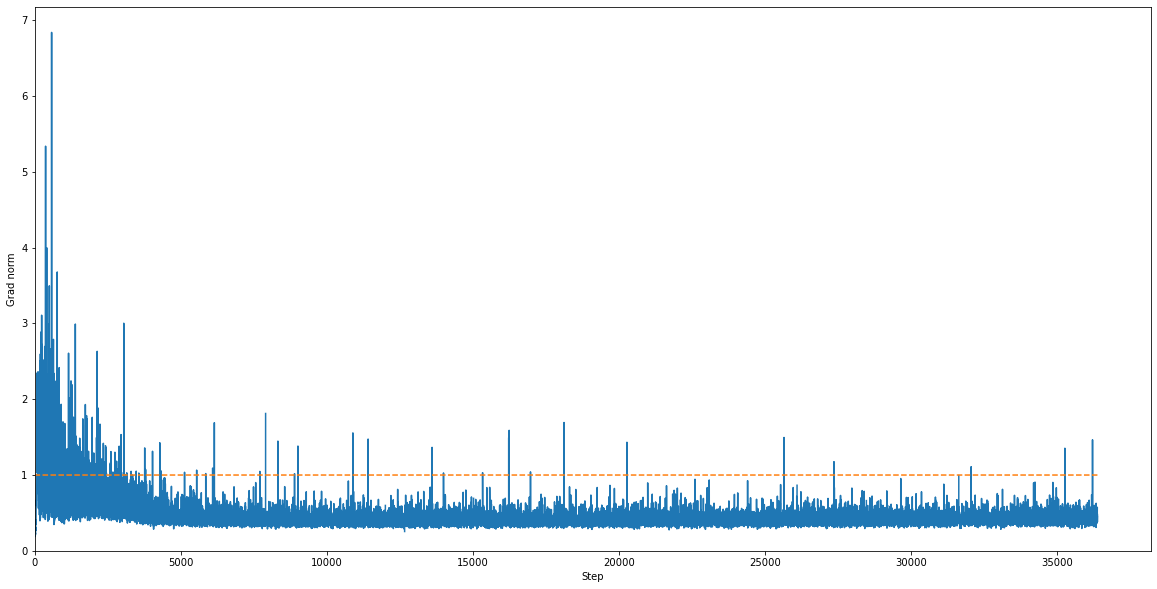

In [45]:
plt.figure(figsize=(20, 10))
plt.plot(gnorms)
plt.plot([config.clip_norm] * len(gnorms), "--")
plt.xlim(0)
plt.ylim(0)
plt.xlabel("Step")
plt.ylabel("Grad norm")
plt.show()

# Submission

In [46]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(inputs=['./checkpoints/rnn'], output='./checkpoints/rnn/avg_last_5_checkpoint.pt', num_epoch_checkpoints=5, num_update_checkpoints=None, checkpoint_upper_bound=None)
averaging checkpoints:  ['./checkpoints/rnn\\checkpoint46.pt', './checkpoints/rnn\\checkpoint45.pt', './checkpoints/rnn\\checkpoint44.pt', './checkpoints/rnn\\checkpoint43.pt', './checkpoints/rnn\\checkpoint42.pt']
Finished writing averaged checkpoint to ./checkpoints/rnn/avg_last_5_checkpoint.pt


## Confirm model weights used to generate submission

In [47]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2023-04-03 17:01:55 | INFO | hw5.seq2seq | loaded checkpoint checkpoints\rnn\avg_last_5_checkpoint.pt: step=unknown loss=3.779629945755005 bleu=18.16307789179446
2023-04-03 17:01:55 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-03 17:02:12 | INFO | hw5.seq2seq | example source: i thought i'd begin with a scene of war .
2023-04-03 17:02:12 | INFO | hw5.seq2seq | example hypothesis: 我想我從一場戰爭開始 。
2023-04-03 17:02:12 | INFO | hw5.seq2seq | example reference: 我想從一個戰爭的場景來開始談 。
2023-04-03 17:02:12 | INFO | hw5.seq2seq | validation loss:	3.7523
2023-04-03 17:02:12 | INFO | hw5.seq2seq | BLEU = 18.84 47.3/24.4/13.6/8.0 (BP = 1.000 ratio = 1.019 hyp_len = 113935 ref_len = 111811)


## Generate Prediction

In [48]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [49]:
generate_prediction(model, task)

2023-04-03 17:02:12 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020\test.en-zh.en
2023-04-03 17:02:12 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020\test.en-zh.zh
2023-04-03 17:02:12 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 test en-zh 4000 examples


prediction:   0%|          | 0/17 [00:00<?, ?it/s]

# Back-translation

## Train a backward translation model

1. Switch the source_lang and target_lang in **config** 
2. Change the savedir in **config** (eg. "./checkpoints/transformer-back")
3. Train model

## Generate synthetic data with backward model 

### Download monolingual data

In [ ]:
mono_dataset_name = 'mono'

In [ ]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted_zh_corpus.deduped.gz"
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        else:
            !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

### TODO: clean corpus

1. remove sentences that are too long or too short
2. unify punctuation

hint: you can use clean_s() defined above to do this

### TODO: Subword Units

Use the spm model of the backward model to tokenize the data into subword units

hint: spm model is located at DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

### Binarize

use fairseq to binarize data

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

### TODO: Generate synthetic data with backward model

Add binarized monolingual data to the original data directory, and name it with "split_name"

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

then you can use 'generate_prediction(model, task, split="split_name")' to generate translation prediction

In [ ]:
# # Add binarized monolingual data to the original data directory, and name it with "split_name"
# # ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
# !cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
# !cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
# !cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
# !cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [ ]:
# hint: do prediction on split='mono' to create prediction_file
# generate_prediction( ... ,split=... ,outfile=... )

### TODO: Create new dataset

1. Combine the prediction data with monolingual data
2. Use the original spm model to tokenize data into Subword Units
3. Binarize data with fairseq

In [ ]:
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
# 
# hint: tokenize prediction_file with the spm model
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
# hint: use fairseq to binarize these two files again
# binpath = Path('./DATA/data-bin/synthetic')
# src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
# tgt_dict_file = src_dict_file
# monopref = ./DATA/rawdata/mono/mono.tok # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
# if binpath.exists():
#     print(binpath, "exists, will not overwrite!")
# else:
#     !python -m fairseq_cli.preprocess\
#         --source-lang 'zh'\
#         --target-lang 'en'\
#         --trainpref {monopref}\
#         --destdir {binpath}\
#         --srcdict {src_dict_file}\
#         --tgtdict {tgt_dict_file}\
#         --workers 2

In [ ]:
# # create a new dataset from all the files prepared above
# !cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

# !cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
# !cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
# !cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
# !cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

Created new dataset "ted2020_with_mono"

1. Change the datadir in **config** ("./DATA/data-bin/ted2020_with_mono")
2. Switch back the source_lang and target_lang in **config** ("en", "zh")
2. Change the savedir in **config** (eg. "./checkpoints/transformer-bt")
3. Train model

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html
11. https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW05/HW05.ipynb